<h1><center>Projet 9</center></h1>

# <center>SOMMAIRE</center>
## [CONTEXTE DU PROJET](#1)<a class="anchor" id="sommaire"></a>
## [IMPORT DES LIBRAIRIES](#2)<a class="anchor" id="sommaire"></a>
## [FONCTIONS PERSONNELLES](#3)<a class="anchor" id="sommaire"></a>
## [LES DONNEES DU PROJET](#4)<a class="anchor" id="sommaire"></a>
## [NETTOYAGE](#5)<a class="anchor" id="sommaire"></a>
## [Correction de l'effet température : ](#6)<a class="anchor" id="sommaire"></a>
### [1-1 Analyse des variables](#7)<a class="anchor" id="sommaire"></a>
### [1-2 Régression linéaire pour corriger l'effet température](#8)<a class="anchor" id="sommaire"></a>
## [Transformation pour rendre stationnaire la série : ](#9)<a class="anchor" id="sommaire"></a>
### [2-1 Méthode de la soustraction de la moyenne mobile](#10)<a class="anchor" id="sommaire"></a>
### [2-2 Méthode différenciation](#12)<a class="anchor" id="sommaire"></a>
## [Prédictions : ](#13)<a class="anchor" id="sommaire"></a>
### [3-1 Méthode de Holt Winters](#14)<a class="anchor" id="sommaire"></a>
### [3-2 Méthode SARIMA](#15)<a class="anchor" id="sommaire"></a>
### [Focus sur les prédictions à 1 an des 2 modèles](#16)<a class="anchor" id="sommaire"></a>
## [CONCLUSION](#17)<a class="anchor" id="sommaire"></a>
## [Annexes : Autre méthode pour décomposer une série temporelle](#18)<a class="anchor" id="sommaire"></a>

## [CONTEXTE DU PROJET](#sommaire)<a class="anchor" id="1"></a>

<p>Vous êtes employé chez Enercoop, société coopérative qui s'est développée grâce à la libéralisation du marché de l’électricité en France. Elle est spécialisée dans les énergies renouvelables.</p>

<p>La plupart de ces énergies renouvelables est cependant intermittente, il est donc difficile de prévoir les capacités de production d'électricité. De plus, la demande en électricité des utilisateurs varie au cours du temps, et dépend de paramètres comme la météo (température, luminosité, etc.) Tout le challenge est de mettre en adéquation l'offre et la demande !</p>

## [IMPORTATION DES LIBRAIRIES](#sommaire)<a class="anchor" id="2"></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns
import datetime as dt
from pylab import rcParams
from plotnine import *
from scipy.stats import chi2_contingency
from scipy.stats import iqr
from scipy.stats import ttest_rel
from scipy.stats import normaltest
from scipy.stats import levene
from scipy.cluster.hierarchy import linkage, fcluster
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, SpectralClustering
from functions import *
import matplotlib.ticker as mtick
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error  
from sklearn.model_selection import StratifiedKFold
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.compose import ColumnTransformer
import pickle
from sklearn import neighbors, metrics
from P7_code_aide import *
import unicodedata
import string_grouper as sg
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import itertools
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
from scipy.stats import skewtest
register_matplotlib_converters()
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# on utilisera un pipeline pour enchaîner les traitements
from sklearn.pipeline import Pipeline

# les méthodes de prétraitement
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

# les outils de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)

## [Fonctions personnelles](#sommaire)<a class="anchor" id="3"></a>

In [2]:
#Fonction de vérification clés primaires

def cle_primaire(dataframe, colonnes) :
    valle = dataframe[dataframe.duplicated(colonnes)]
    print(f"Est-ce que les colonnes ({colonnes}) sont un ensemble clé primaire ?")
    if valle.empty :
        print("Oui !")
    else :
        print("Non !")
        print(valle)

#Fonction pour centrer reduire les valeurs d'un dataframe 

def centre_reduit(dataframe):
    data_centre_reduit = dataframe
    for i in data_centre_reduit.columns:
        data_centre_reduit[i] = (data_centre_reduit[i] - np.mean(data_centre_reduit[i]))/np.std(data_centre_reduit[i])
    return data_centre_reduit

#Fonction pour rajouter des colonnes booleennes pour identifier les outliers

def Affichage_outliers(table_analyse, colonnes) :
    datab = table_analyse.copy()
    for i in datab.loc[:,colonnes].columns :

        Q1 = np.quantile(datab[i], 0.25)
        Q3 = np.quantile(datab[i], 0.75)
        IQR = iqr(datab[i])

        mask = (datab[i] < (Q1 - 1.5 * IQR))|(datab[i] > (Q3 + 1.5 * IQR))
        titre = "outliers " + i
        datab[titre] = False
        datab.loc[mask,titre] = True
    return datab

def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

        
def round_spe(l, target):
    cumul = np.array(np.round(np.cumsum(l))).astype('int')
    cumul = np.insert(cumul, 0, 0)
    i=1
    new=np.zeros(l.shape[0])
    while i != cumul.shape[0]:
        new[i-1] = cumul[i] - cumul[i-1]
        i += 1
    return new

def get_stationarity(timeseries):

    timeseries = timeseries.dropna()
    # Statistiques mobiles
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()

    # tracé statistiques mobiles
    plt.figure(figsize=(16,9))
    original = plt.plot(timeseries, color='blue', label='Origine')
    mean = plt.plot(rolling_mean, color='red', label='Moyenne Mobile')
    std = plt.plot(rolling_std, color='black', label='Ecart-type Mobile')
    plt.legend(loc='best')
    plt.title('Moyenne et écart-type Mobiles')
    plt.xticks(rotation=90)
    plt.show(block=False)

    # Test Dickey–Fuller :
    result = adfuller(timeseries)
    print('Statistiques ADF : {}'.format(result[0]))
    print('p-value : {}'.format(result[1]))
    print('Valeurs Critiques :')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

## [LES DONNES DU PROJET](#sommaire)<a class="anchor" id="4"></a>

In [3]:
Elec = pd.read_csv("Elec.csv", encoding = "ISO-8859-3")
Temp = pd.read_csv("temp.csv", encoding = "UTF-16")

## [NETTOYAGE](#sommaire)<a class="anchor" id="5"></a>

In [4]:
Elec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1182 entries, 0 to 1181
Data columns (total 22 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Mois                                      1182 non-null   object 
 1   Qualité                                   1182 non-null   object 
 2   Territoire                                1182 non-null   object 
 3   Production totale                         1182 non-null   int64  
 4   Production nucléaire                      732 non-null    float64
 5   Production thermique totale               1182 non-null   int64  
 6   Production thermique charbon              793 non-null    float64
 7   Production thermique fioul                1182 non-null   int64  
 8   Production thermique gaz                  1182 non-null   int64  
 9   Production hydraulique                    1182 non-null   int64  
 10  Production éolien                   

In [5]:
Elec.describe(include = "all")

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,Production éolien,Production solaire,Production bioénergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique
count,1182,1182,1182,1182.000000,732.000000,1182.000000,793.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1098.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
unique,102,2,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2019-06,Données définitives,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,13,948,102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,7296.699662,8602.269126,545.642978,177.385876,36.001692,390.082064,873.906091,321.627750,111.540609,114.441624,6041.213198,740.626594,6972.784314,2630.529412,918.676471,610.931373,1463.196078,1149.745098,198.254902
std,NaN,NaN,NaN,12163.736443,10115.326951,1090.506615,359.772157,89.572746,803.191554,1603.864291,602.295918,216.140544,184.306108,10755.316830,3187.692016,1185.055955,948.245380,441.560535,659.586973,406.116065,598.916789,1267.072831
min,NaN,NaN,NaN,92.000000,618.000000,-3.000000,-10.000000,-4.000000,-1.000000,0.000000,1.000000,0.000000,7.000000,0.000000,-7949.000000,3536.000000,643.000000,-798.000000,-726.000000,341.000000,-322.000000,-2912.000000
25%,NaN,NaN,NaN,560.750000,3137.000000,32.250000,0.000000,0.000000,18.000000,5.000000,61.000000,13.000000,35.000000,1792.250000,-1497.250000,6268.750000,2082.250000,759.500000,183.500000,1208.750000,642.750000,-574.000000
50%,NaN,NaN,NaN,3658.500000,5311.000000,173.500000,18.000000,7.000000,122.000000,70.500000,121.000000,33.000000,60.000000,2937.500000,0.000000,7072.000000,2477.500000,1008.500000,629.500000,1506.500000,1187.000000,227.500000
75%,NaN,NaN,NaN,7281.500000,7349.750000,537.000000,208.000000,24.000000,350.750000,862.500000,265.000000,107.000000,92.000000,4518.000000,3674.750000,7863.250000,3156.000000,1230.750000,1076.750000,1768.250000,1618.750000,1006.000000


In [6]:
Elec["Territoire"].unique()

array(['France', 'Grand-Est', 'Nouvelle-Aquitaine',
       'Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne',
       'Centre-Val de Loire', 'Ile-de-France', 'Occitanie', 'Normandie',
       'Hauts-de-France', 'PACA', 'Pays-de-la-Loire'], dtype=object)

**Les DJU étant propres à chaque région, nous allons nous concentrer sur une seule région, l'Ile-de-France**

In [7]:
Elec = Elec[Elec["Territoire"] == 'Ile-de-France']

In [8]:
Temp

,Annee,Jan,Fév,Mar,Avr,Mai,Jun,Jui,Aoû,Sep,Oct,Nov,Déc
0,2019,405,268,233,169,118,24,0,2,27,134,283,327
1,2018,303,433,314,120,56,8,0,3,34,122,283,326
2,2017,468,278,206,183,75,9,1,7,63,99,283,369
3,2016,364,322,321,212,88,28,6,3,12,176,286,391
4,2015,392,366,276,141,92,16,7,6,72,177,195,248
5,2014,324,282,224,136,100,19,8,19,16,92,223,368
6,2013,429,402,377,210,158,44,1,5,42,105,304,350
7,2012,336,436,202,230,83,35,12,2,58,155,296,346
8,2011,392,305,243,78,43,31,15,12,23,128,227,313
9,2010,499,371,295,165,141,23,0,11,52,172,310,512


**Pour simplifier le traitement, nous remplaçons tous les noms des mois par leurs équivalents numériques**

In [9]:
Temp.columns = ["Annee", "01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

**Nous réorganisons la table des DJU pour différencier chaque par l'ensemble mois et année**

In [10]:
Temp = pd.melt(Temp, id_vars = "Annee", value_vars=Temp.columns[1:],\
                        var_name="Mois", value_name="DJU").sort_values(by=["Annee", "Mois"])

**Nous renommons les mois pour passer à une forme comprise par la librairie 'datetime' : année -  mois**

In [11]:
Temp["Mois"] = Temp["Annee"].map(str) + "-" + Temp["Mois"].map(str)

In [12]:
Temp

,Annee,Mois,DJU
10,2009,2009-01,487
21,2009,2009-02,366
32,2009,2009-03,293
43,2009,2009-04,135
54,2009,2009-05,82
65,2009,2009-06,40
76,2009,2009-07,3
87,2009,2009-08,1
98,2009,2009-09,27
109,2009,2009-10,150


In [13]:
print(Elec.shape)
print(Temp.shape)

(90, 22)
(132, 3)


**Nous fusionnons les deux tables en une seul**

In [14]:
fusion = pd.merge(Elec, Temp, left_on = "Mois", right_on = "Mois", how = "inner")

**Nous allons identifier les mois où nous n'avons aucune données**

In [15]:
fusion[fusion["Consommation totale"] == 0]

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,Production éolien,Production solaire,Production bioénergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique,Annee,DJU
0,2013-01,Données définitives,Ile-de-France,870,NaN,753,195.0,37,520,0,3,0,112,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,429
1,2013-02,Données définitives,Ile-de-France,779,NaN,668,141.0,41,484,0,3,2,105,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,402
2,2013-03,Données définitives,Ile-de-France,886,NaN,769,242.0,61,466,3,2,3,106,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,377
3,2013-04,Données définitives,Ile-de-France,291,NaN,194,113.0,30,49,4,3,6,82,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,210
4,2013-05,Données définitives,Ile-de-France,141,NaN,39,23.0,15,0,0,2,6,92,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,158
5,2013-06,Données définitives,Ile-de-France,192,NaN,90,76.0,12,1,3,2,7,89,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,44
6,2013-07,Données définitives,Ile-de-France,213,NaN,81,65.0,15,0,6,2,9,113,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,1
7,2013-08,Données définitives,Ile-de-France,206,NaN,90,89.0,0,0,5,1,8,100,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,5
8,2013-09,Données définitives,Ile-de-France,295,NaN,204,188.0,13,1,5,2,5,77,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,42
9,2013-10,Données définitives,Ile-de-France,323,NaN,199,185.0,8,4,3,3,3,113,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,105


**Il manque des données de consommation sur 2013, nous allons eliminer cette année.**

In [16]:
mask = fusion["Consommation totale"] == 0
mask = mask[mask == True]
fusion = fusion.drop(mask.index)
fusion = fusion.set_index("Mois", drop=True)
fusion

,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,Production éolien,Production solaire,Production bioénergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique,Annee,DJU
Mois,,,,,,,,,,,,,,,,,,,,,,,
2014-01,Données définitives,Ile-de-France,455,NaN,337,107.0,4,226,1,5,1,109,7612,-7156.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,324
2014-02,Données définitives,Ile-de-France,307,NaN,192,16.0,-1,177,0,6,2,104,6749,-6442.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,282
2014-03,Données définitives,Ile-de-France,406,NaN,280,73.0,19,188,4,2,6,112,6509,-6102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,224
2014-04,Données définitives,Ile-de-France,206,NaN,76,68.0,8,0,6,2,6,113,5396,-5190.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,136
2014-05,Données définitives,Ile-de-France,179,NaN,46,44.0,2,0,5,3,8,115,5279,-5100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,100
2014-06,Données définitives,Ile-de-France,149,NaN,47,48.0,0,0,3,2,9,86,4815,-4666.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,19
2014-07,Données définitives,Ile-de-France,126,NaN,1,0.0,1,0,3,1,7,110,4889,-4763.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,8
2014-08,Données définitives,Ile-de-France,116,NaN,0,-1.0,1,0,5,2,7,102,4355,-4238.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,19
2014-09,Données définitives,Ile-de-France,214,NaN,111,100.0,10,0,4,1,7,89,4874,-4659.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,16


## [Correction de l'effet température](#sommaire)<a class="anchor" id="6"></a>

### [Analyse graphiques des deux variables](#sommaire)<a class="anchor" id="7"></a> 

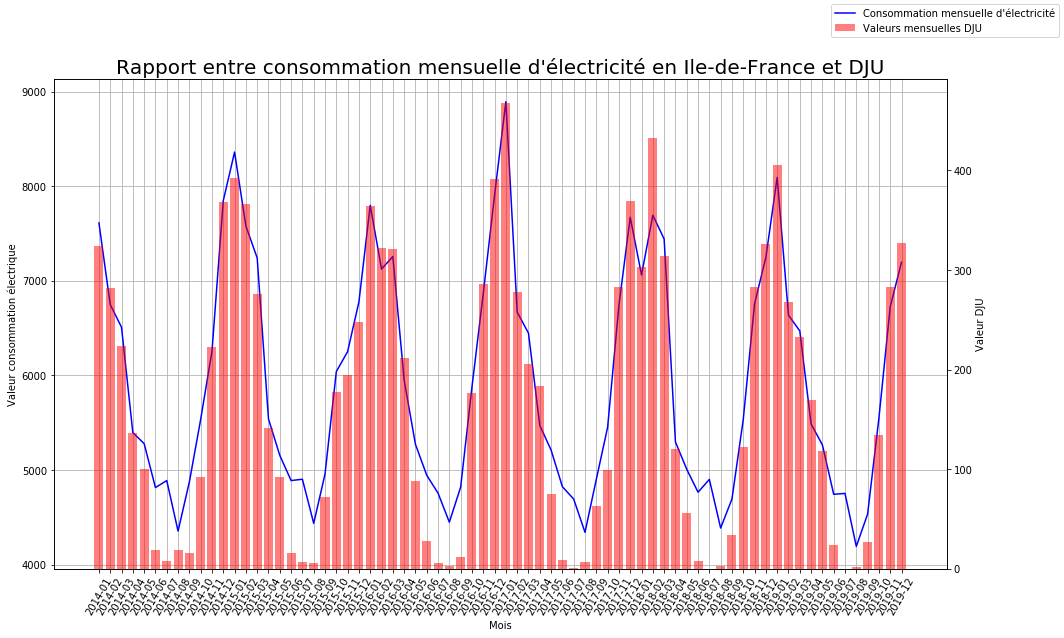

In [17]:
fig, ax1 = plt.subplots(figsize=(16,9))


plt.xticks(rotation=60)
ax1.plot(fusion["Consommation totale"], color = "b", label = "Consommation mensuelle d'électricité")
ax1.set_ylabel("Valeur consommation électrique")
ax1.set_xlabel("Mois")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.bar(x=fusion.index,height=fusion["DJU"], color = "r", label = "Valeurs mensuelles DJU", alpha = 0.5)
ax2.set_ylabel("Valeur DJU")

plt.title("Rapport entre consommation mensuelle d'électricité en Ile-de-France et DJU", size = 20)
fig.legend()
ax1.grid()
plt.draw()

**On remarque que malgré les échelles différentes que les deux variables sont totalement corrélée, les valeurs croissent et décroissent ensembles.**

### [Régression linéaire pour corriger l'effet température](#sommaire)<a class="anchor" id="8"></a>

In [18]:
#créer y et X
y=fusion["Consommation totale"]
X=fusion["DJU"]

In [19]:
sm.OLS(y,X)

In [20]:
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     Consommation totale   R-squared:                       0.964
Model:                             OLS   Adj. R-squared:                  0.964
Method:                  Least Squares   F-statistic:                     1888.
Date:                 Thu, 17 Dec 2020   Prob (F-statistic):           2.23e-52
Time:                         18:35:10   Log-Likelihood:                -492.48
No. Observations:                   72   AIC:                             989.0
Df Residuals:                       70   BIC:                             993.5
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4510.3590     42.417    106.33

This distribution has skew -0.0955063469275896
This distribution has kurtosis -0.21242333850766126
Test Shapiro-Wilk : hypothèse de normalité ne peut pas être rejetée : 0.9139689243897031


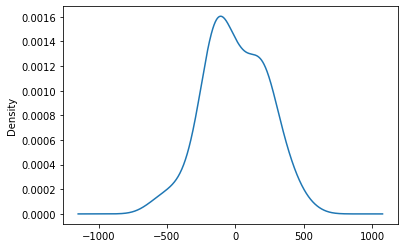

In [21]:
norm = results.resid
norm.plot(kind = 'density')
print('This distribution has skew', norm.skew())
print('This distribution has kurtosis', norm.kurt())

k2, p = normaltest(results.resid)
alpha = 0.05

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print(f"Test Shapiro-Wilk : hypothèse de normalité peut être rejetée : {p}")
else:
    print(f"Test Shapiro-Wilk : hypothèse de normalité ne peut pas être rejetée : {p}")

**On teste ici la normalité des résidus, confirmé par l'indice de skewness et la pvalue de Shapiro-Wilk à 0,13 qui confirme l'hypothèse d'une distribution normale.**

**On confirme le graphique, avec seulement la température nous expliquons 96% de la variance**

**Nous soustraions la variable température au modèle, pour récupérer des données non influencées par la température**

In [22]:
reg_lin = fusion["Consommation totale"] - fusion["DJU"]*results.params["DJU"]

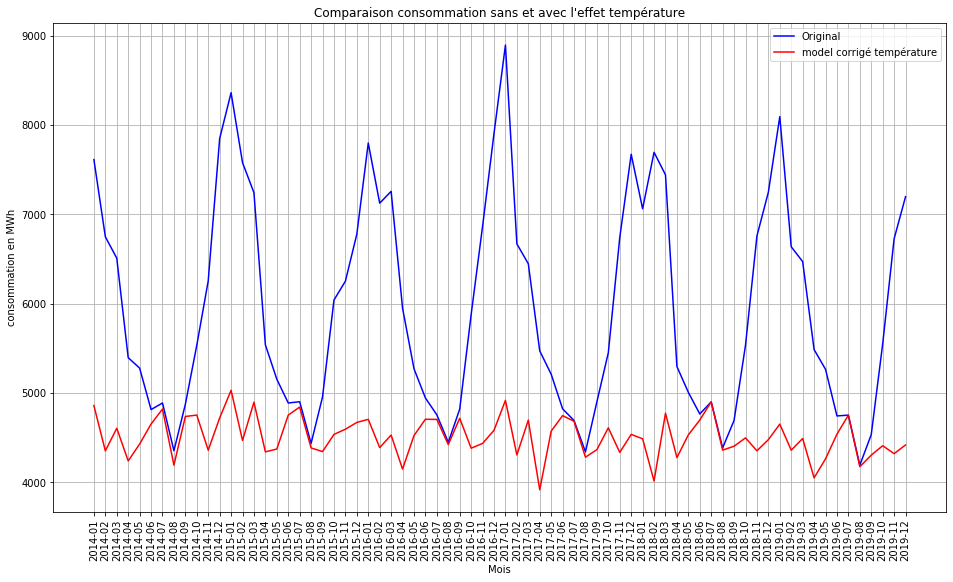

In [23]:
plt.figure(figsize=(16,9))
plt.plot(fusion["Consommation totale"], color = "b", label = "Original")
plt.plot(reg_lin, color = "r", label = "model corrigé température")
plt.xticks(rotation=90)
plt.ylabel("consommation en MWh")
plt.xlabel("Mois")
plt.title("Comparaison consommation sans et avec l'effet température")
plt.legend()
plt.grid()
plt.draw()

**On constate qu'une fois l'effet température supprimé la saisonnalité est beaucoup moins forte.**

## [Transformation pour rendre stationnaire la série](#sommaire)<a class="anchor" id="9"></a>

<p><b>Pour effectuer des prédictions sur des séries temporelles correctes, il faut d'abord stationnarisé la série temporelle.</b></p>
<p><b>Ce qui signifie qu'il faut que la série temporelle n'ait pas de tendance, ni de saisonnalité</b></p>

Nous testons d'abord la stationnarité de notre série corrigée : 
<ol> 
    <li>Via représentation graphique en cherchant à rendre parallèle la moyenne mobile, ainsi que l'Ecart-type mobile</li>
    <li>Le test de Dickey-Fuller permet de tester la stationnarité.</li> 
</ol>

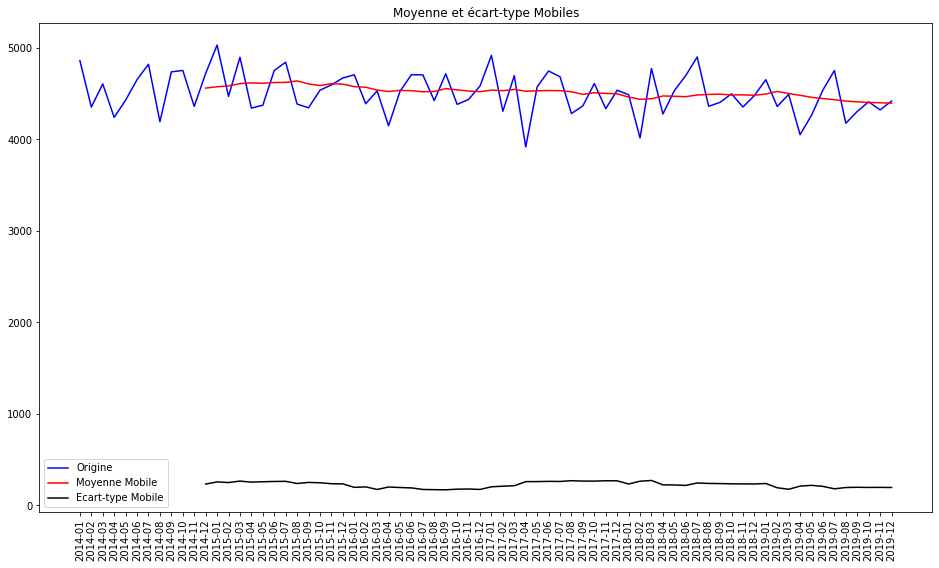

Statistiques ADF : -9.43222052303522
p-value : 5.153520960086725e-16
Valeurs Critiques :
	1%: -3.526004646825607
	5%: -2.9032002348069774
	10%: -2.5889948363419957


In [24]:
get_stationarity(reg_lin)

**Même si la moyenne mobile et l'écart-type mobile semblent à peu près parallèles visuellement, le test de Dickey-Fuller augmenté montre par la p-value que l'hypothèse de stationnarité n'est pas vérifié.**

### [Méthode de la soustraction de la moyenne mobile](#sommaire)<a class="anchor" id="10"></a>

**Nous allons tenter de stationnariser la série via la soustraction de la moyenne-mobile**

In [25]:
rolling_mean_test = reg_lin.rolling(window=12, min_periods = 12).mean()

**Notre moyenne-mobile aura une fenêtre de 12 valeurs correspondant à 12 mois, car notre saisonnalité se fait sur une année**

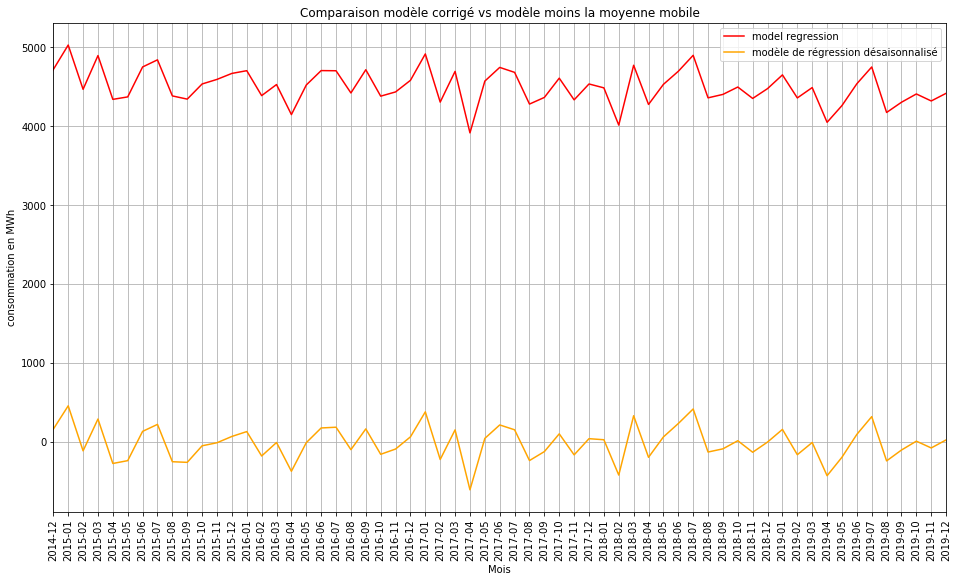

In [26]:
plt.figure(figsize=(16,9))
plt.plot(reg_lin, color = "r", label = "model regression")
plt.plot((reg_lin - rolling_mean_test), color = "orange", label = "modèle de régression désaisonnalisé")
plt.xticks(rotation=90)
plt.xlim("2014-12", "2019-12")
plt.ylabel("consommation en MWh")
plt.xlabel("Mois")
plt.title("Comparaison modèle corrigé vs modèle moins la moyenne mobile")
plt.legend()
plt.grid()
plt.draw()

**On voit ici que le but était de stabiliser la moyenne de la série autour de zéro, ceci afin de supprimer la tendance.**

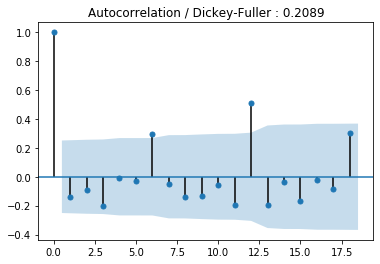

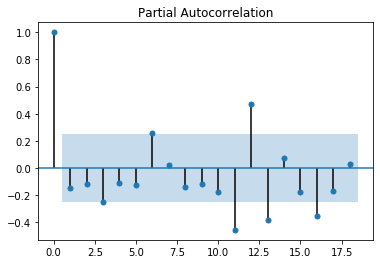

In [27]:
timeseries = (reg_lin - rolling_mean_test).dropna()


plot_acf(timeseries)
plt.title("Autocorrelation / Dickey-Fuller : " + str(round(adfuller(timeseries)[1],4)))
plt.show
plot_pacf(timeseries)
plt.show()

**La série n'est pas stationnaire, Même si l'autocorrélation ne montre pas de décroissance vers 0 significatif d'une série non stationnaire, le test de Dickey-Fuller ne confirme pas l'hypothèse de stationnarité**

### [Méthode différenciation](#sommaire)<a class="anchor" id="12"></a>

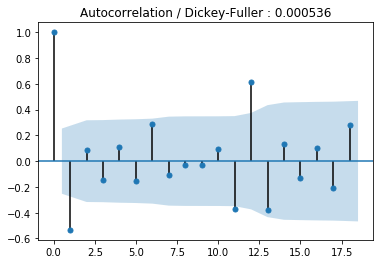

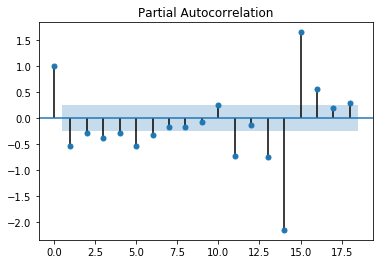

In [28]:
df_log_shift = timeseries.diff().dropna()

plot_acf(df_log_shift)
plt.title("Autocorrelation / Dickey-Fuller : " + str(round(adfuller(df_log_shift)[1],6)))
plt.show
plot_pacf(df_log_shift)
plt.show()

**La série est stationnaire, confirmé par le test de Dickey-Fuller et l'absence de décroissance vers 0 sur l'autocorrelation.**

## [Prédictions](#sommaire)<a class="anchor" id="13"></a>

### [Méthode de Holt Winters](#sommaire)<a class="anchor" id="14"></a>

In [29]:
fit2 = ExponentialSmoothing(df_log_shift+(abs(df_log_shift.min())+1), seasonal_periods=12, trend=None, seasonal='add').fit(use_boxcox=False)
new_index = fit2.forecast(12).index.astype(str).str[:-3]
holt_prediction = pd.concat([fit2.fittedvalues, fit2.forecast(12).reindex(new_index)])
holt_prediction = holt_prediction-(abs(df_log_shift.min())+1)
holt_prediction["2015-01"] = (holt_prediction["2015-01"]+timeseries.shift()+rolling_mean_test)["2015-01"]
holt_prediction = holt_prediction.cumsum()

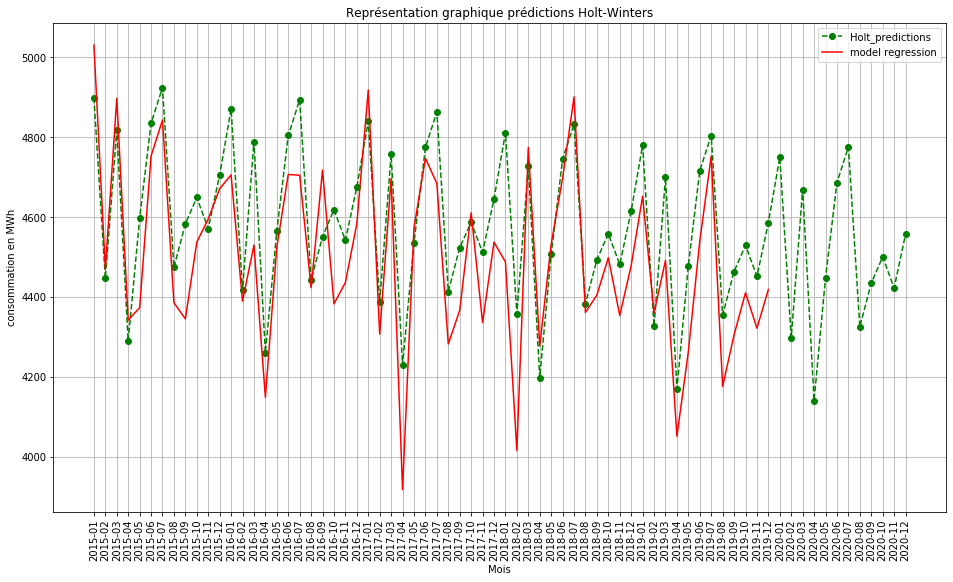

In [30]:
plt.figure(figsize=(16,9))
plt.plot(holt_prediction, marker='o', linestyle='dashed', color='green', label = "Holt_predictions")
plt.plot(reg_lin["2015-01":], color = "r", label = "model regression")


plt.xticks(rotation=90)
plt.ylabel("consommation en MWh")
plt.xlabel("Mois")
plt.title("Représentation graphique prédictions Holt-Winters")
plt.legend()
plt.grid()
plt.draw()

In [31]:
y_forecasted = holt_prediction.loc['2019-01':'2019-12']
y_truth = reg_lin['2019-01':]
mse = mean_squared_error(y_forecasted, y_truth)
percent_error = np.mean(np.abs((y_truth.values - y_forecasted.values) / y_truth.values))*100
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))
print('The Mean Absolute Percentage Error is {}%'.format(round(percent_error, 2)))

The Mean Squared Error is 22577.75
The Root Mean Squared Error is 150.26
The Mean Absolute Percentage Error is 3.21%


**Le modèle Holt Winters a déjà un MAPE de 3.21% ce qui démontre déjà une bonne efficacité.**

### [Méthode SARIMA](#sommaire)<a class="anchor" id="15"></a>

In [32]:
#Sarima_df = (reg_lin - reg_lin.shift()).dropna()
Sarima_df = df_log_shift
Sarima_df = Sarima_df.reindex(pd.to_datetime(Sarima_df.index))
y = Sarima_df.copy()
y = pd.DataFrame(y, columns = ["Mois, Consommation"])

In [33]:
p = range(0, 3)
d = range(0, 2)
q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
best_aic = 0
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            if ((best_aic == 0) | (best_aic > results.aic)) & (results.pvalues.max() <= 0.05)\
            & (sm.stats.diagnostic.acorr_ljungbox(results.resid,lags=[12], return_df=False)[1]>0.05) :
                best_aic = results.aic
                best_pvalue = results.pvalues.max()
                best_param = param
                best_param_seasonal = param_seasonal
        except: 
            continue
print('Meilleurs paramètres : SARIMAX{}x{} - AIC:{}'.format(best_param,best_param_seasonal,best_aic))

mod = sm.tsa.statespace.SARIMAX(y,
                                order=(best_param),
                                seasonal_order=(best_param_seasonal),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

Meilleurs paramètres : SARIMAX(0, 0, 1)x(2, 1, 0, 12) - AIC:313.62856999320286
                                      SARIMAX Results                                      
Dep. Variable:                  Mois, Consommation   No. Observations:                   60
Model:             SARIMAX(0, 0, 1)x(2, 1, [], 12)   Log Likelihood                -152.814
Date:                             Thu, 17 Dec 2020   AIC                            313.629
Time:                                     18:35:53   BIC                            318.341
Sample:                                 01-01-2015   HQIC                           314.879
                                      - 12-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5163      

**Modèle SARIMA (0, 0, 1)x(2, 1, 0, 12) avec AIC 313,628. Optimisé au niveau AIC, représentativité et blancheur des résidus. Valeur P>|z| aucune avec une représentativité significative.**

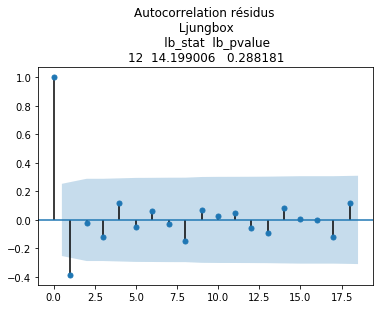

In [34]:
plot_acf(results.resid)
plt.title("Autocorrelation résidus \n Ljungbox \n"+str(sm.stats.diagnostic.acorr_ljungbox(results.resid,lags=[12], return_df=True)))
plt.show()

**Comme on peut le voir il n'y a pas de corrélation entre les résidus en regardant le corrolélogramme, confirmé par le test de blancheur des résidus avec pvalue 0,28, supérieur à 0.05.**

This distribution has skew -0.439543418480271
This distribution has kurtosis 0.8484512859588667
Test Shapiro-Wilk : hypothèse de normalité ne peut pas être rejetée 
 pvalue = 0.13924600300710077


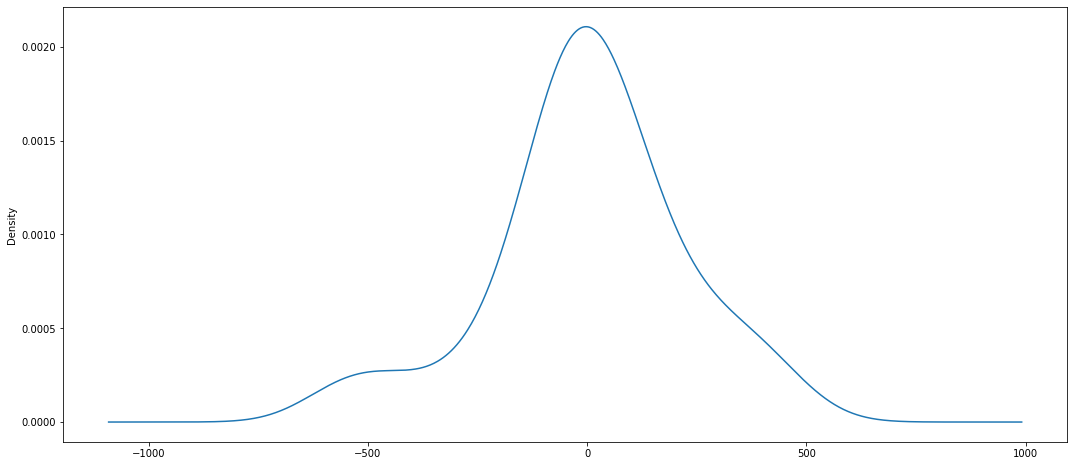

In [42]:
norm = results.resid
norm.plot(kind = 'density')
print('This distribution has skew', norm.skew())
print('This distribution has kurtosis', norm.kurt())

k2, p = normaltest(results.resid)
alpha = 0.05

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print(f"Test Shapiro-Wilk : hypothèse de normalité peut être rejetée \n pvalue = : {p}")
else:
    print(f"Test Shapiro-Wilk : hypothèse de normalité ne peut pas être rejetée \n pvalue = {p}")

**On teste ici la normalité des résidus, confirmé par l'indice de skewness et la pvalue de Shapiro-Wilk à 0,13 qui confirme l'hypothèse d'une distribution normale.**

In [36]:
pred = results.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
y_forecasted = (pred.predicted_mean+timeseries.shift()+rolling_mean_test).dropna()\
.append(pd.Series(results.get_forecast(steps=12).predicted_mean))
y_forecasted = y_forecasted.reindex(y_forecasted.index.astype(str).str[:-3])
y_forecasted["2019-12":] = y_forecasted["2019-12":].cumsum()

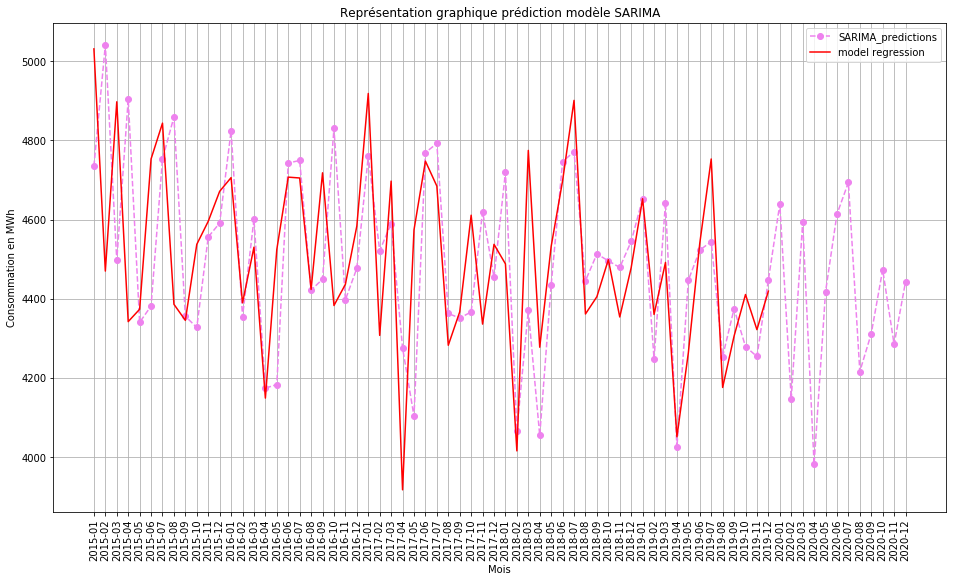

In [37]:
plt.figure(figsize=(16,9))
plt.plot(y_forecasted, marker='o', linestyle='dashed', color='violet', label = "SARIMA_predictions")
plt.plot(reg_lin["2015-01":], color = "r", label = "model regression")


plt.xticks(rotation=90)
plt.ylabel("Consommation en MWh")
plt.xlabel("Mois")
plt.title("Représentation graphique prédiction modèle SARIMA")
plt.legend()
plt.grid()
plt.draw()

In [38]:
y_truth = reg_lin['2019-01':]
y_fore = y_forecasted['2019-01':'2019-12']
mse = mean_squared_error(y_fore, y_truth)
percent_error = np.mean(np.abs((y_truth.values - y_fore.values) / y_truth.values))*100
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))
print('The Mean Absolute Percentage Error is {}%'.format(round(percent_error, 2)))

The Mean Squared Error is 12261.81
The Root Mean Squared Error is 110.73
The Mean Absolute Percentage Error is 2.03%


### [Focus sur les prédictions à 1 an des 2 modèles](#sommaire)<a class="anchor" id="16"></a>

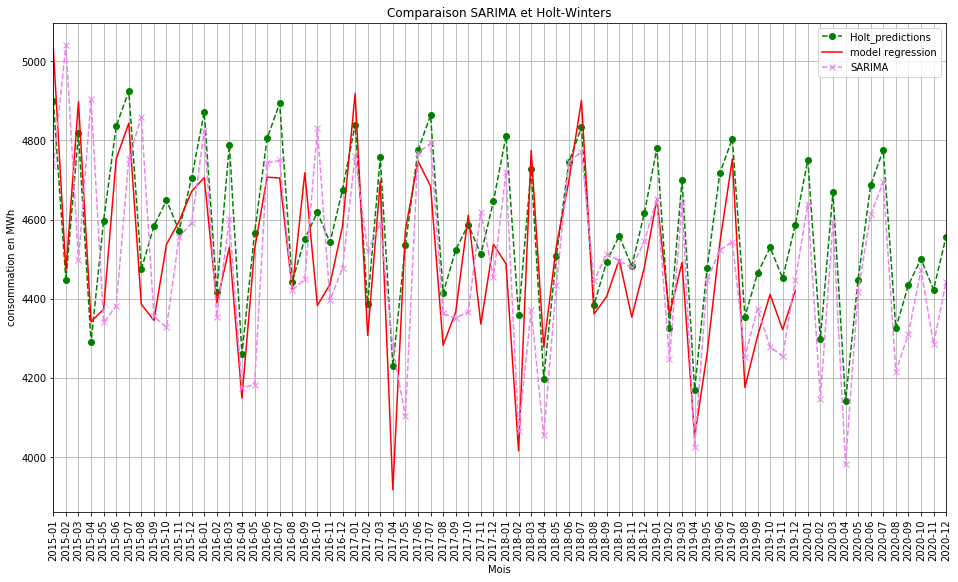

In [39]:
plt.figure(figsize=(16,9))
plt.plot(holt_prediction, marker='o', linestyle='dashed', color='green', label = "Holt_predictions")
plt.plot(reg_lin["2015-01":], color = "r", label = "model regression")
plt.plot(y_forecasted, color = "violet", marker='x', linestyle='dashed', label = "SARIMA")



plt.xticks(rotation=90)
plt.xlim("2015-01", "2020-12")
plt.ylabel("consommation en MWh")
plt.xlabel("Mois")
plt.title("Comparaison SARIMA et Holt-Winters")
plt.legend()
plt.grid()
plt.draw()

**La méthode SARIMA améliore la prédiction de 1.18% par rapport à la méthode Holt Winters**

## [Conclusion](#sommaire)<a class="anchor" id="17"></a>

<p>Dans le domaine de l’électricité la prédiction est d’une importance capitale, afin d’adapter au mieux les moyens de production et d’éviter des coupures.</p>

<p>Comme on a pu le constater la température est fortement corrélée à la consommation électrique, seulement pour prédire la consommation il faut la soustraire aux données en déterminant sont coefficient de régression.</p>

<p>Mais l’étape la plus importante est de stationnariser notre série temporelle afin d’avoir le modèle de prédiction le plus efficace possible et éviter l’influence d’une tendance ou d’une saisonnalité, plusieurs méthodes existes dans notre cas le décalage temporelle a été le plus efficace.</p>

<p>On a pu utiliser ensuite deux méthodes pour prédire notre futur consommation : Holt-Winters et son double lissage exponentiel et SARIMA.<br>
Au final le modèle SARIMA est le plus performant avec un pourcentage moyen d’erreur absolu à 2,03 %, une amélioration de 1,18 % par rapport à la méthode Holt-Winters.</p>

## [Annexes : Autre méthode pour décomposer une série temporelle](#sommaire)<a class="anchor" id="18"></a>

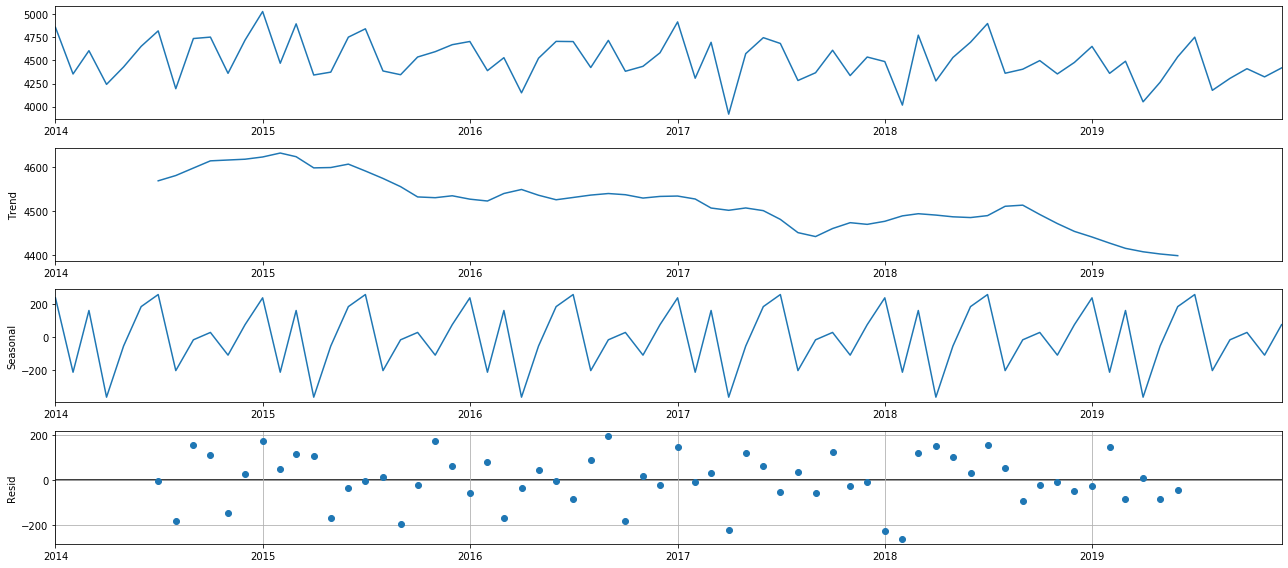

In [40]:
y = reg_lin 
y = y.reindex(pd.to_datetime(y.index))
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.grid()
plt.show()